# Setup

In [1]:
import scanpy as sc
import scvi
import os
import shutil
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from ipywidgets import *
import warnings
import scrublet as scr

Global seed set to 0
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
sc.settings.figdir = "/notebook/Joe/M-cells/analysis/figs_for_paper"
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code'

# Import data

In [14]:
adata = sc.read_10x_h5("../data/SC3_v3_NextGem_DI_CellPlex_Mouse_PBMC_10K_Multiplex_count_raw_feature_bc_matrix.h5")
adata.var_names_make_unique()

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
adata.layers["counts"] = adata.X.copy()
adata.obs["batch"] = "10X"

In [16]:
adata

AnnData object with n_obs × n_vars = 1649890 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

# Preprocessing

In [17]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## QC filter

In [8]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True, save_path=None):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    ax =sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    ax.set(yscale="log")
    ax.set(xscale="log")
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

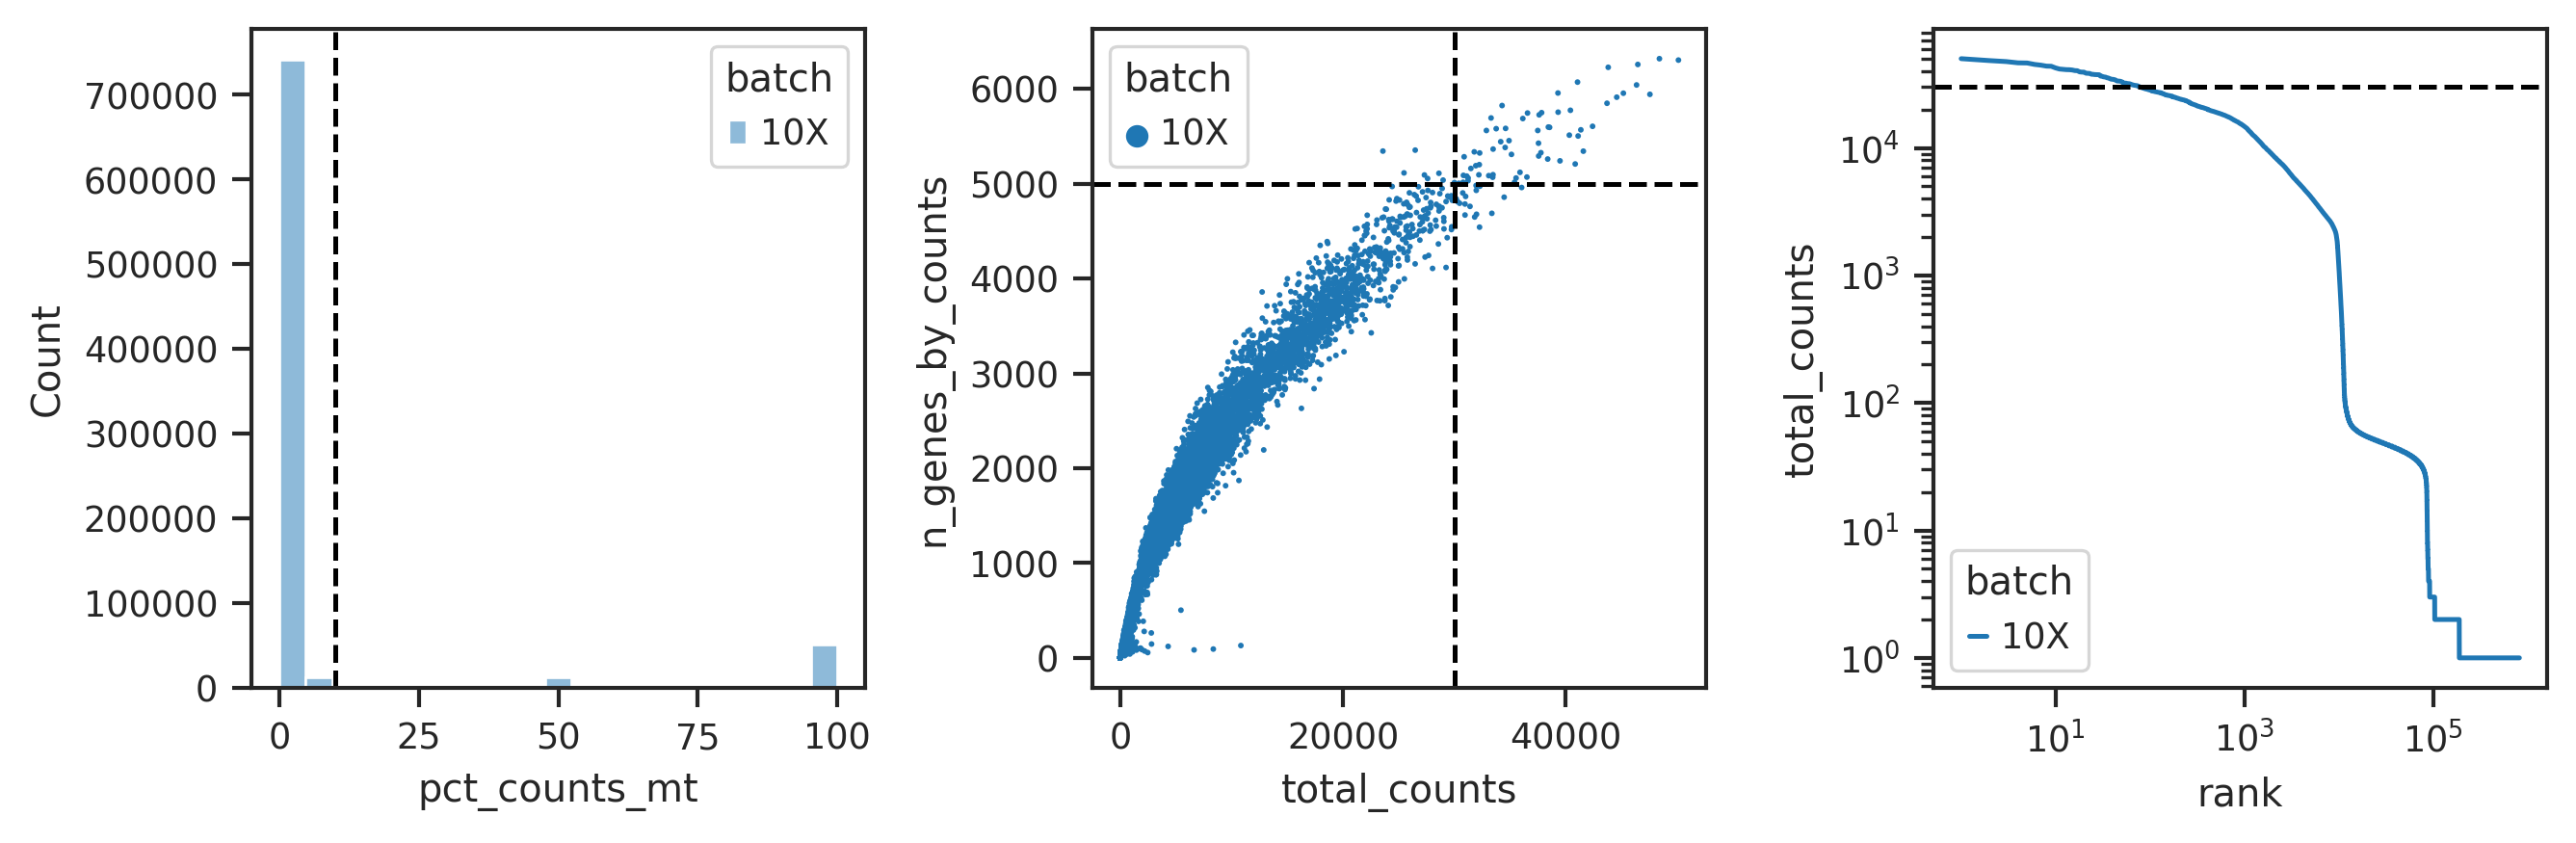

In [18]:
# save a copy of the unfiltered data
adataUnfiltered = adata.copy()

# Set thresholds
totalCountsThreshold = 30000
numGenesThreshold = 5000
mtThreshold = 10

# Check QC thresholds before filtering
qc_plot(adata, totalCountsThreshold, numGenesThreshold, mtThreshold)

In [19]:
# Filter cells based on thresholds
adataFiltered = adata[adata.obs.pct_counts_mt <= mtThreshold].copy()
adataFiltered = adataFiltered[adataFiltered.obs.total_counts <= totalCountsThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.total_counts >= 1000]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts <= numGenesThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts >= 500]

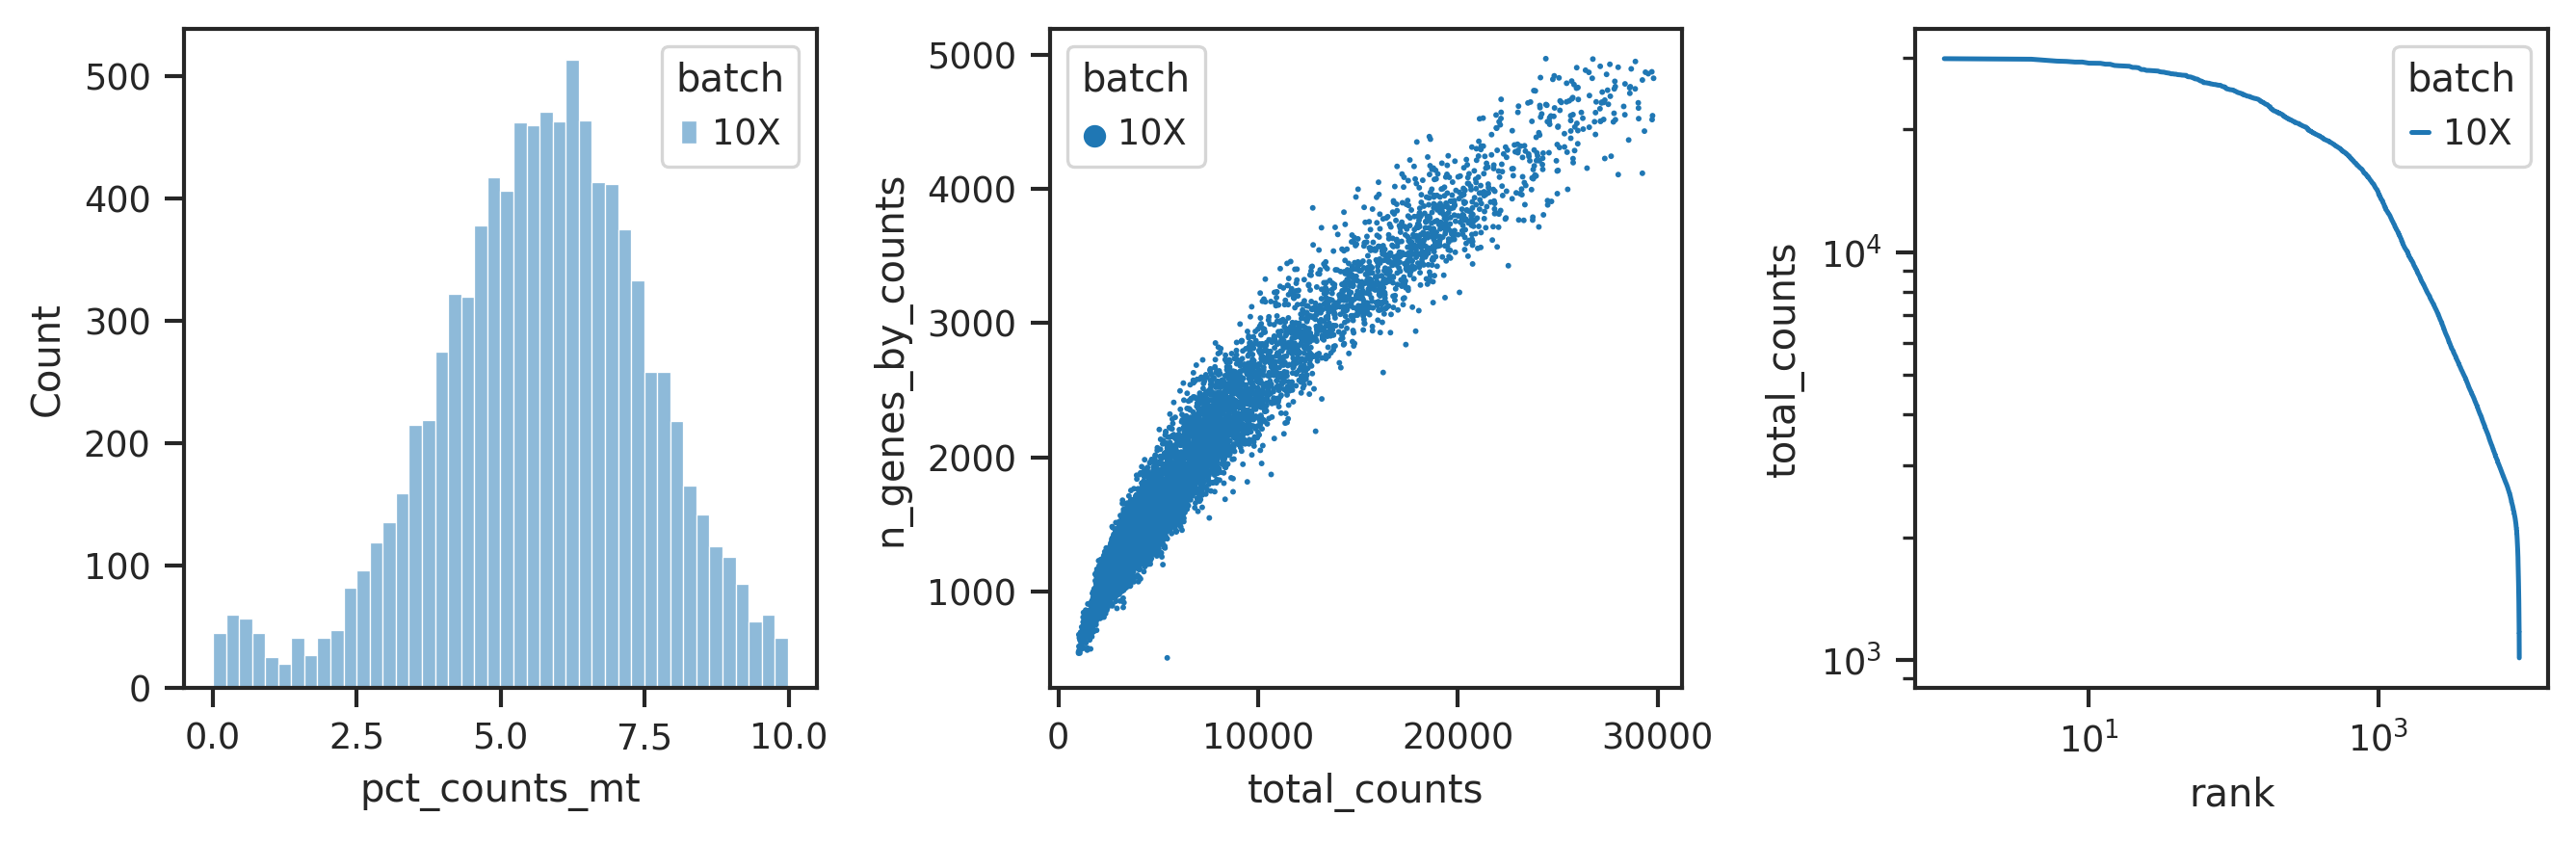

In [20]:
qc_plot(adataFiltered, show_thresh=False)

In [21]:
# overwrite original adata variable with the filtered data
adata = adataFiltered

# Clean up to save memory 
del adataFiltered

In [22]:
adata

View of AnnData object with n_obs × n_vars = 9421 × 20540
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'counts'

## Normalize data (scanpy)

In [23]:
# Scanpy preprocessing pipeline
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# scVI training

In [24]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

In [25]:
# Train scVI model
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:64: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [17:49<00:00,  2.66s/it, loss=5.04e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [17:49<00:00,  2.67s/it, loss=5.04e+03, v_num=1]


In [26]:
# Checl save paths
if not os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/"):
    os.makedirs("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/")
    
if not os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/"):
    os.makedirs("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/")
    
if os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/PBMC_all_genes"):
    shutil.rmtree("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/PBMC_all_genes")
    
# save the scVI model and adata object before further processing because training is non-deterministic
model.save("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/PBMC_all_genes")
adata.write("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/PBMC_all_genes.h5ad")

# Dimensionality reduction

In [27]:
adata = sc.read("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/PBMC_all_genes.h5ad")

In [28]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [29]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.25,)

In [30]:
adata

AnnData object with n_obs × n_vars = 9421 × 20540
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scVI_normalized'
    obsp: 'distances', 'connectivities'

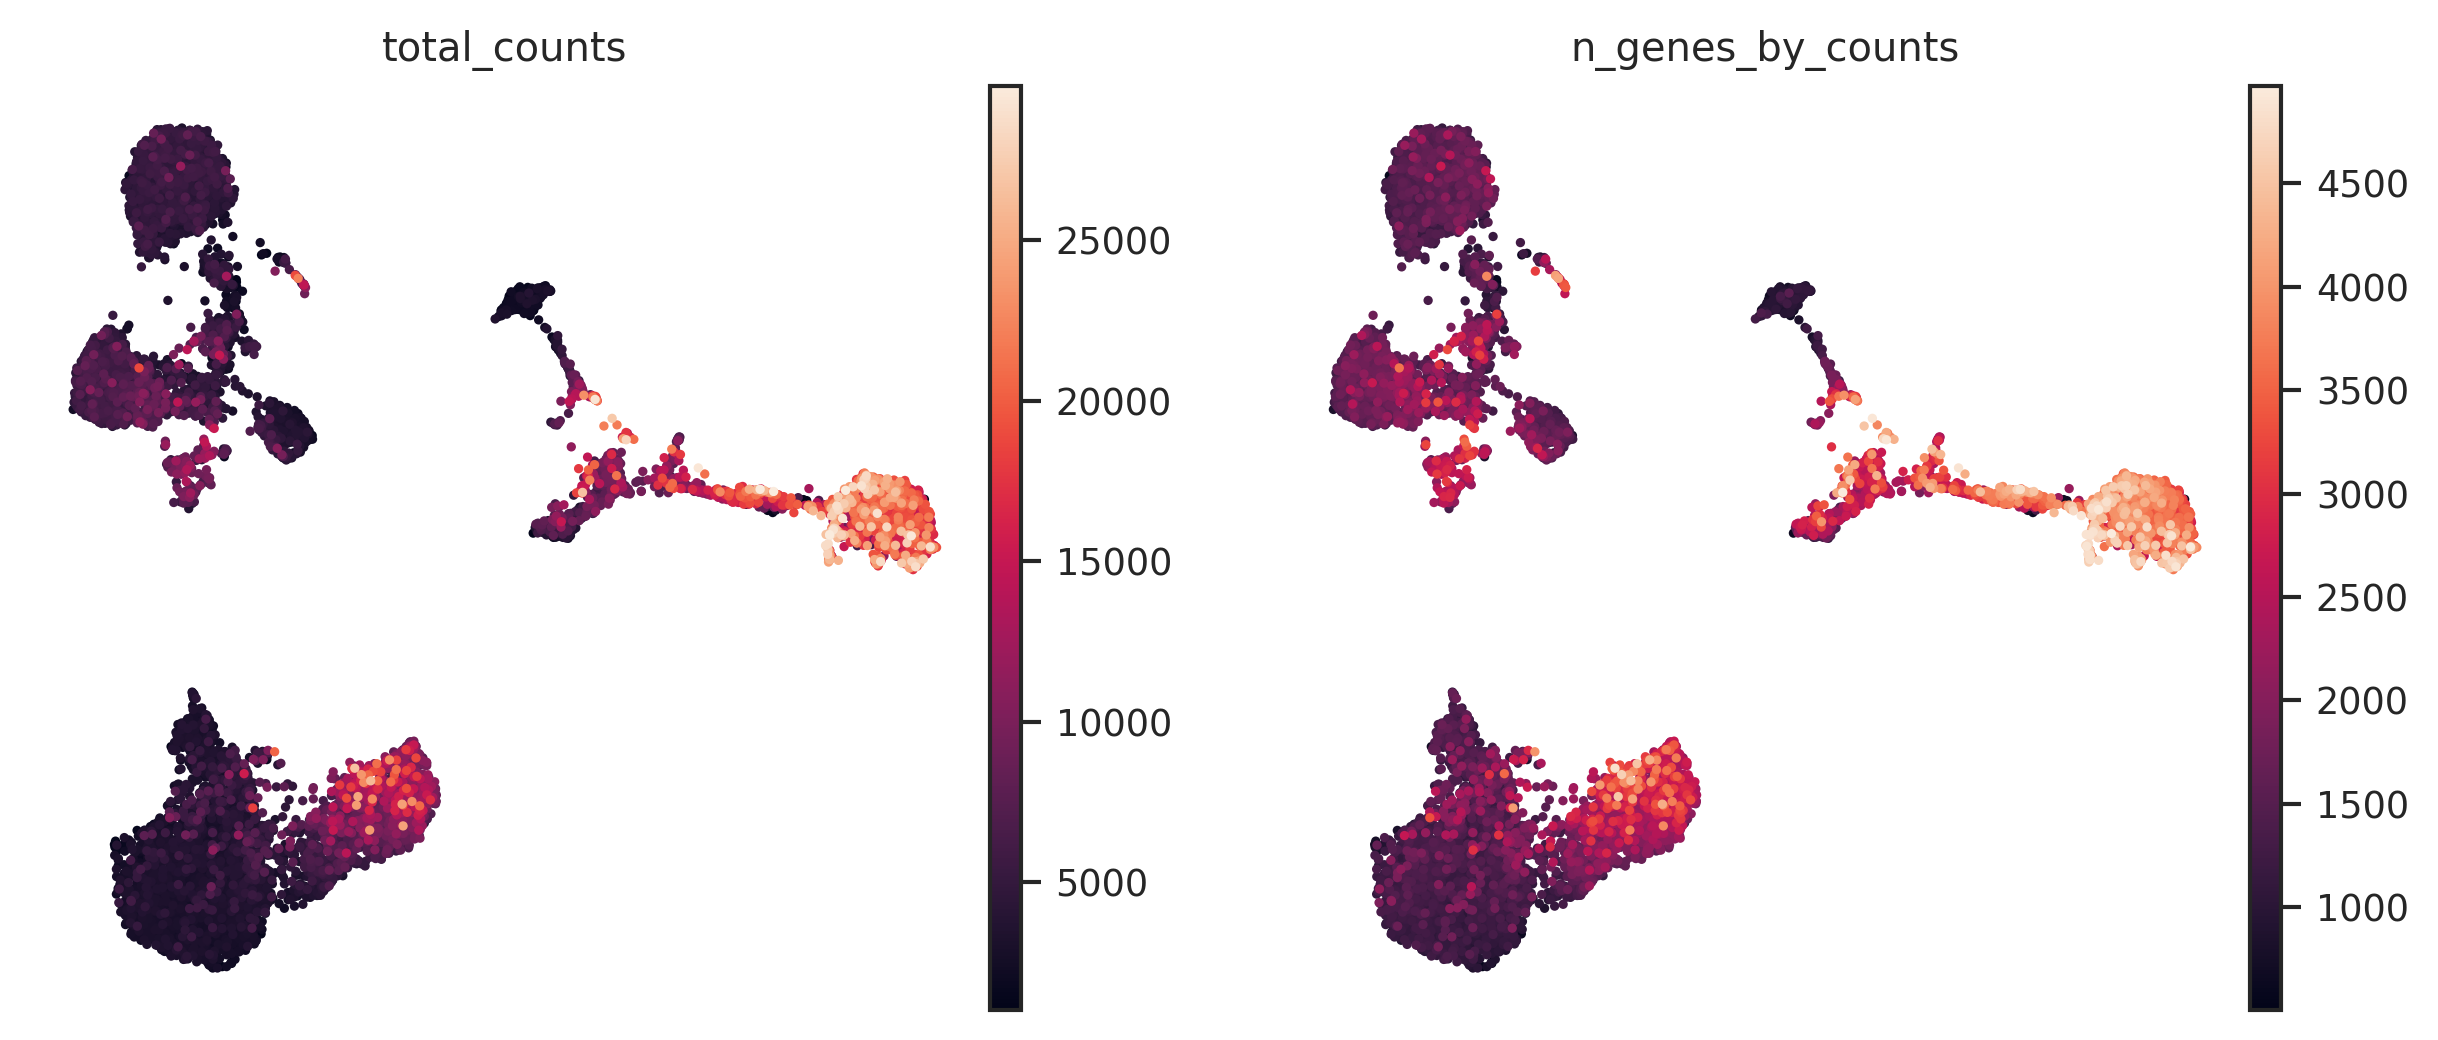

In [31]:
# Check dimensionality reduction for batch effects
sc.pl.umap(
    adata,
    color=["total_counts", "n_genes_by_counts"],
    s=20,
)

# Clustering

/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


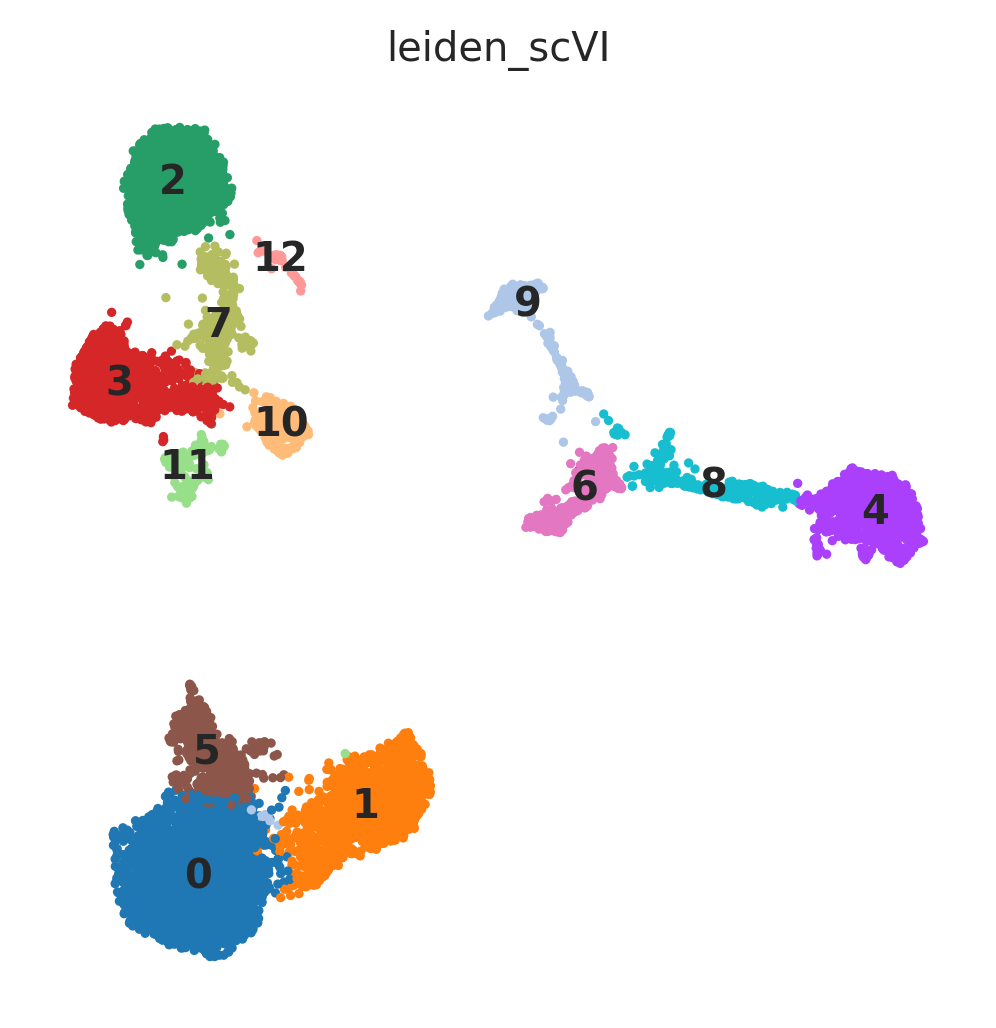

In [32]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
    s=20,
)

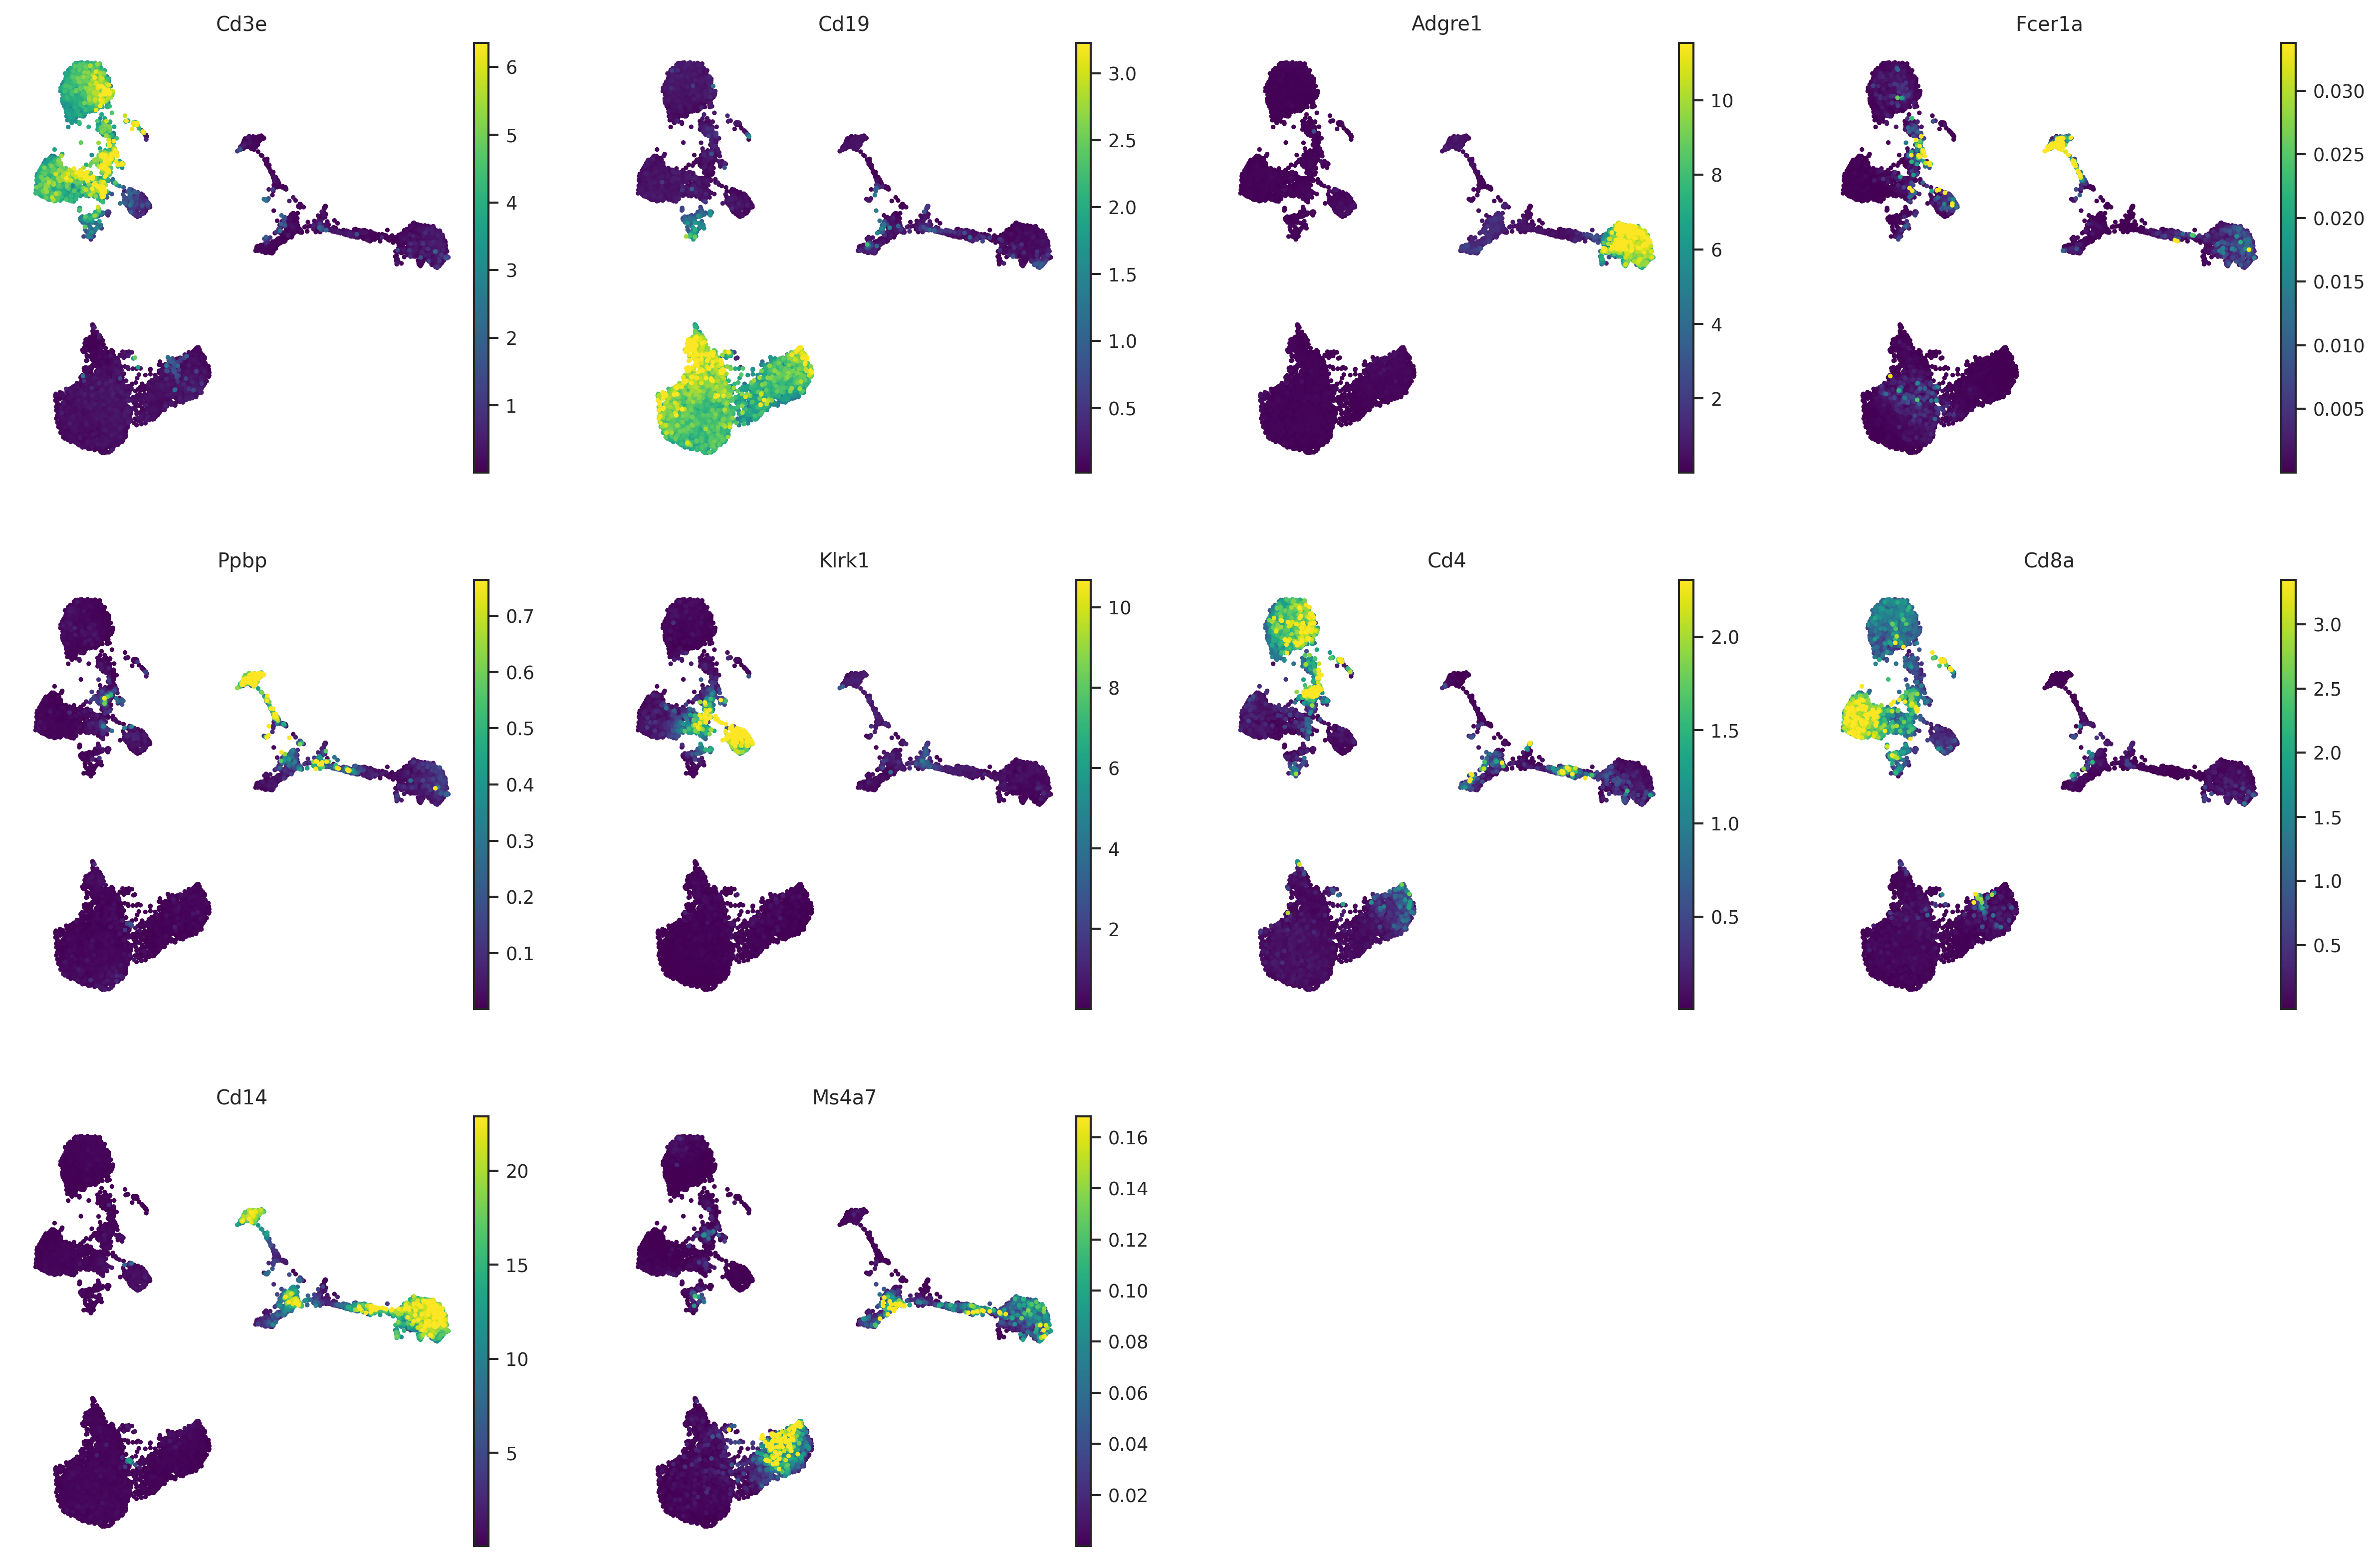

In [39]:
# Rename leiden clusters with corresponding cell types
cellTypes = {
    "0": "B-1",
    "1": "B-2",
    "5": "B-3",
    "10": "NK",
    "7": "DP T",
    "2": "CD4 T 1",
    "12": "CD4 T 2",
    "3": "CD8 T 1",
    "11": "CD8 T 2",
    "4": "Mac",
    "9": "DCs",
    "6": "Mo 1",
    "8": "Mo 2"
}
adata.obs["cell_type"] = adata.obs.leiden_scVI.replace(cellTypes)

# Filter non mTECs/Junk clusters


# Plot key marker genes
geneList = ["Cd3e", "Cd19", "Adgre1", "Fcer1a", "Ppbp", "Klrk1", "Cd4", "Cd8a", "Cd14", "Ms4a7"]
vmin=[]
vmax=[]
for gene in geneList:
    vmin.append(np.quantile(adata[:, gene].layers["scVI_normalized"], 0.01))
    vmax.append(np.quantile(adata[:, gene].layers["scVI_normalized"], 0.99))
sc.pl.umap(
    adata,
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    s=20,
)

/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


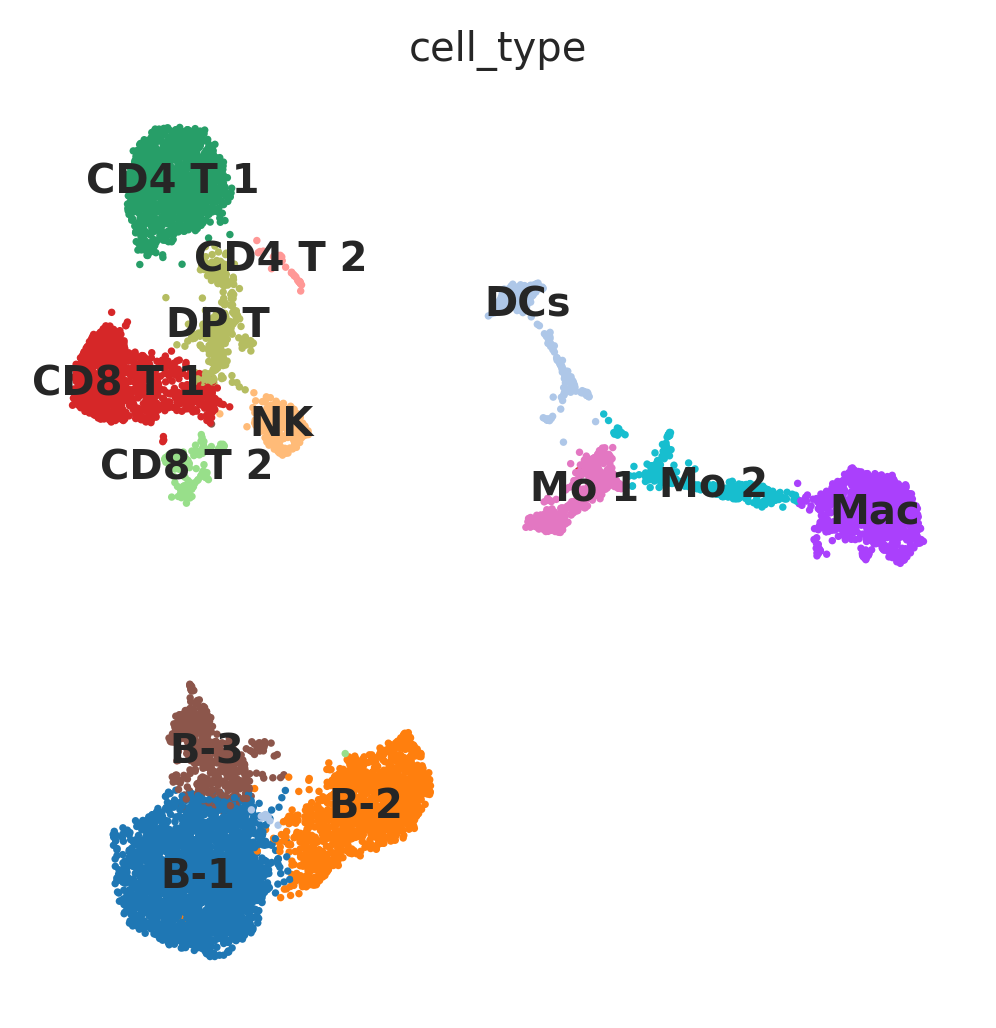

In [40]:
sc.pl.umap(
    adata,
    color="cell_type",
    legend_loc = "on data",
)

# Save Anndata

In [41]:
adata.write("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/PBMC_all_genes.h5ad")